In [1]:
import pandas as pd
import pickle
import imp
import networkx as nx
from nxpd import draw
from sqlalchemy import create_engine

# Taxonomic network diagrams

Recent work developing a new catchment model for Norway ([here](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_model.ipynb)) has required learning some basic [graph theory](https://en.wikipedia.org/wiki/Graph_theory). Although my work so far has focused on how to use this for representing hydrological networks, exactly the same principles apply to taxonomic relationships. In fact, I think some of my recent catchment modelling code might work directly with the NCBI database with almost no modification. This idea is tested below.

## 1. Connect to RAdb

In [2]:
# Create db connection
r2_func_path = r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template\useful_resa2_code.py'
resa2 = imp.load_source('useful_resa2_code', r2_func_path)

engine, conn = resa2.connect_to_resa2()

## 2. Read NCBI database

In [3]:
# Read entire NCBI into memory
sql = ("SELECT a.tax_id, a.parent_tax_id, a.rank, b.name_txt "
       "FROM risk_assessment.ncbi_nodes a, "
       "risk_assessment.ncbi_names b "
       "WHERE a.tax_id = b.tax_id")

df = pd.read_sql(sql, engine)

print 'Total number of organisms in database:', len(df)

Total number of organisms in database: 2322907


In [4]:
df.head()

,tax_id,parent_tax_id,rank,name_txt
0,63,59,species,Vitreoscilla filiformis (ex Pringsheim 1951) S...
1,63,59,species,strain L1401-2
2,64,189773,genus,Herpetosiphon
3,64,189773,genus,Herpetosiphon Holt and Lewin 1968
4,65,64,species,ATCC 23779


## 3. Build taxonomic network

In [5]:
# Build graph
g = nx.DiGraph()

# Add nodes
for idx, row in df.iterrows():
    nd = row['tax_id']
    g.add_node(nd, rank=row['rank'], name=row['name_txt'])

# Add edges
for idx, row in df.iterrows():
    fr_nd = row['parent_tax_id']
    to_nd = row['tax_id']
    g.add_edge(fr_nd, to_nd)

## 4. Save graph to file for ease of re-use

In [6]:
# Save graph 
#out_path = (r'C:\Data\James_Work\Staff\Knut_Eric_T'
#            r'\RA_Database\ncbi_graph.txt')
#pickle.dump(g, open(out_path, 'w'))

## 5. Load graph from file

In [7]:
# To load the file again in future
#g_path = (r'C:\Data\James_Work\Staff\Knut_Eric_T'
#          r'\RA_Database\ncbi_graph.txt')
#
#g = pickle.load(open(g_path))

## 6. Create a function for visualising network relationships

The function below inspects the network and retruns a schematic diagram of either (i) the descendants or (ii) the parents of the specified TAX_ID.

In [8]:
def plot_network(g, tax_id, direct='down'):
    """ Create schematic diagram of parents or children from the 
        specified node.
    
    Args:
        g         NetworkX graph object
        tax_id:   Int. NCBI TAX_ID of interest
        direct:   Str. 'up' or 'down'. Direction to trace (up to parents 
                  or down to descendants)
        
    Returns:
        NetworkX graph. Can be displayed using draw(g2, show='ipynb')        
    """
    import networkx as nx
    
    # Parse direction
    if direct == 'down':
        # Get sub-tree
        g2 = nx.dfs_tree(g, tax_id)
        
        # Update labels 
        for nd in nx.topological_sort(g2):
            g2.node[nd]['label'] = '%s\n%s\n%s' % (nd, 
                                                   g.node[nd]['rank'], 
                                                   g.node[nd]['name'])  
            
    elif direct == 'up':
        # Get sub-tree
        g2 = nx.dfs_tree(g.reverse(), tax_id).reverse()

        # Update labels 
        for nd in nx.topological_sort(g2):
            g2.node[nd]['label'] = '%s\n%s\n%s' % (nd, 
                                                   g.node[nd]['rank'], 
                                                   g.node[nd]['name']) 
            
    else:
        raise ValueError('"direct" must be "up" or "down".')     
    
    return g2

## 7. Visualise descendants

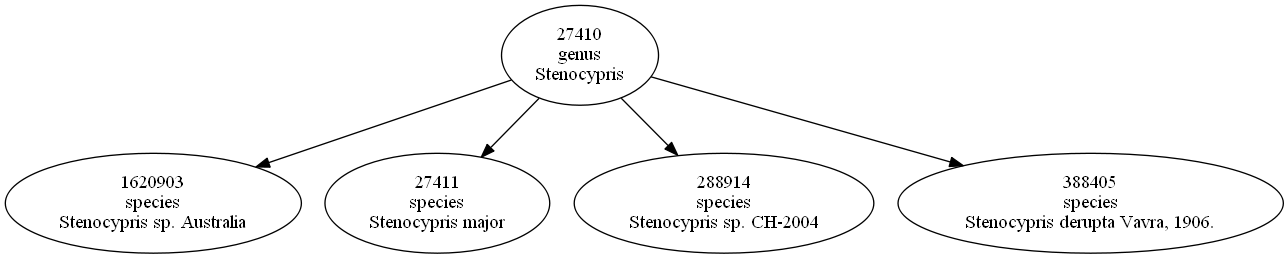

In [9]:
# Plot descendants for TAX_ID 27410 
g2 = plot_network(g, 27410, direct='down')
draw(g2, show='ipynb')

## 8. Visualise parents

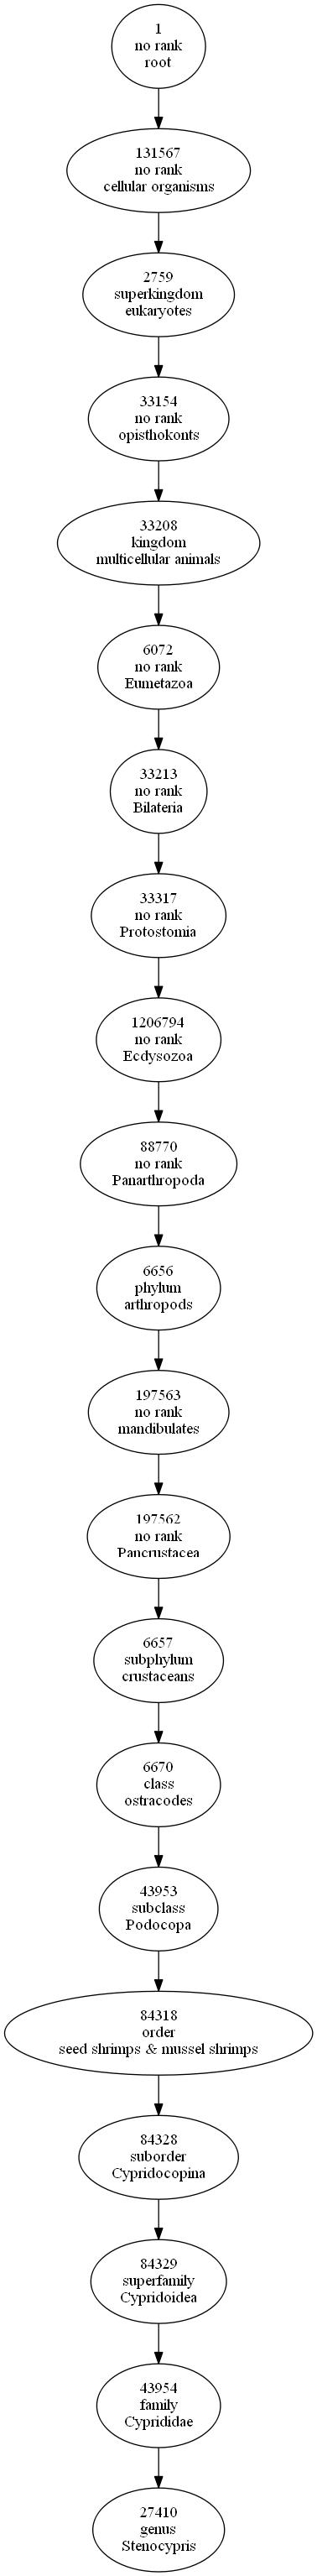

In [10]:
# Plot parents for TAX_ID 27410 
g3 = plot_network(g, 27410, direct='up')
draw(g3, show='ipynb')